What is the purpose of this? 

This model is meant to show that the use of the csvs metric on blinded typical data can be used to predict how a model perfoms on truly cold start examples (pharos)

Trying to show that:

- Deviation behavior on blinded data (CSVS) can be quantified

- The behavior generalizes — can predict model errors on cold-start samples

- So CSVS can act as a model evaluation tool even when no Pharos-type cold-start labels are available

# Protein Level

In [7]:
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from scipy.spatial import ConvexHull

def compute_CHR_per_protein(merged_df):
    #based on convex hull:  how often the model predicts out-of-distribution values when faced with a cold-start protein.
    CHR_dict = {}

    for protein_id, group in merged_df.groupby("Protein_ID"):
        points_unblinded = group[["True_Label", "Unblinded_Prediction"]].values
        points_blinded = group[["True_Label", "Blinded_Prediction"]].values

        if len(points_unblinded) < 3:
            print("<3")
            continue  # Need at least 3 points for a convex hull

        try:
            hull = ConvexHull(points_unblinded)
            polygon = Polygon(points_unblinded[hull.vertices])

            inside_mask = np.array([polygon.covers(Point(p)) for p in points_blinded])
            outside_count = (~inside_mask).sum()
            CHR = outside_count / len(points_blinded)
            CHR_dict[protein_id] = CHR
        except Exception as e:
            print(f"[EXCEPTION] Protein: {protein_id} — {str(e)}")
            continue

    return pd.Series(CHR_dict)


def compute_CSPD_per_protein(merged_df):
    #how much a model’s prediction changes for the same input when the protein is blinded
    merged_df["NPD"] = (
        merged_df["Unblinded_Prediction"] - merged_df["Blinded_Prediction"]
    ) / merged_df["True_Label"]

    CSPD = merged_df.groupby("Protein_ID")["NPD"].mean()
    return CSPD.rename("CSPD")


def compute_CSVS_protein_level(merged_df, alpha=None, beta=None):
    # Step 1: Get per-protein CSPD and CHR
    CSPD_per_protein = compute_CSPD_per_protein(merged_df)
    CHR_per_protein = compute_CHR_per_protein(merged_df)

    # Align proteins
    common_proteins = CSPD_per_protein.index.intersection(CHR_per_protein.index)
    CSPD = CSPD_per_protein.loc[common_proteins].abs()
    CHR = CHR_per_protein.loc[common_proteins]

    # Normalize weights if not provided
    if alpha is None:
        alpha = 1 / CSPD.max()
    if beta is None:
        beta = 1 / CHR.max()

    # Compute CSVS for each protein
    csvs_per_protein = alpha * CSPD + beta * CHR
    print(csvs_per_protein)

    # Return the protein-level CSVS (mean across proteins)
    csvs_model = csvs_per_protein.mean()
    return csvs_model, csvs_per_protein, alpha, beta



379


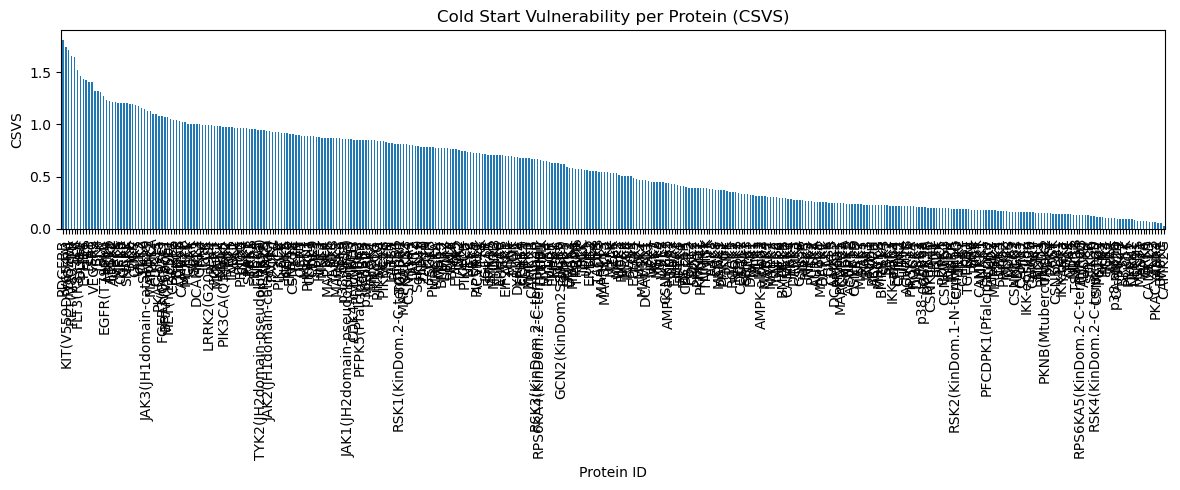

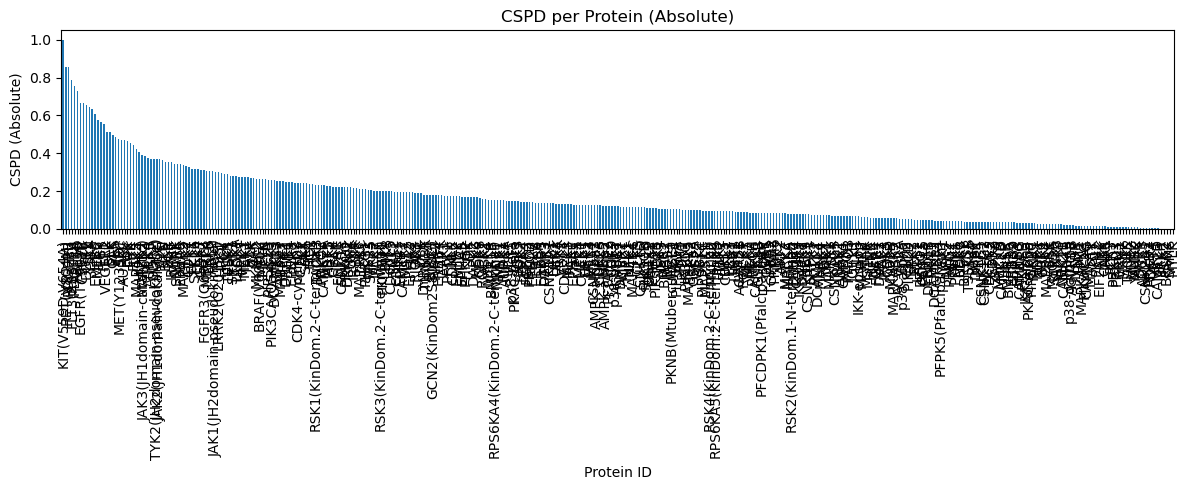

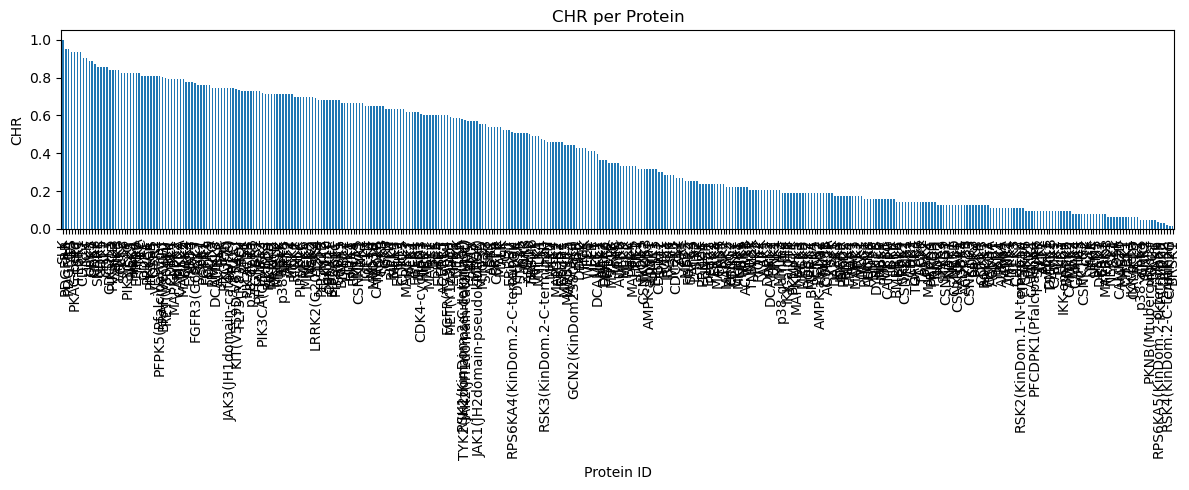

AAK1         0.381659
ABL1p        1.228807
ABL2         0.970616
ACVR1        0.228754
ACVR1B       0.241559
               ...   
ZAP70        0.783261
p38-alpha    0.100806
p38-beta     0.862194
p38-delta    0.851601
p38-gamma    0.211585
Length: 379, dtype: float64
Model-level CSVS: 0.5759
Alpha scaling: 4.5980, Beta scaling: 1.0794


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# File paths
unblinded_file = "new/crossval_predictions_GINConvNet_davis_b3.csv"
blinded_file = "new/concatenated_final_test_predictions.csv"

# Load both files
df_unblinded = pd.read_csv(unblinded_file)
df_blinded = pd.read_csv(blinded_file)

# Rename prediction columns to distinguish
df_unblinded = df_unblinded.rename(columns={"Predicted_Value": "Unblinded_Prediction"})
df_blinded = df_blinded.rename(columns={"Predicted_Value": "Blinded_Prediction"})

# Merge on Drug_ID and Protein_ID
merged_df = pd.merge(
    df_unblinded[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]],
    df_blinded[["Drug_ID", "Protein_ID", "True_Label", "Blinded_Prediction"]],
    on=["Drug_ID", "Protein_ID", "True_Label"]
)

# Compute CSPD and CHR
CSPD_per_protein = compute_CSPD_per_protein(merged_df)
CSPD_abs = CSPD_per_protein.abs()
CHR_per_protein = compute_CHR_per_protein(merged_df)
print(len(CHR_per_protein))

# Normalize weights
alpha = 1 / CSPD_abs.max()
beta = 1 / CHR_per_protein.max()

# Combine into CSVS
csvs = alpha * CSPD_abs + beta * CHR_per_protein

# Plot CSVS
csvs.sort_values(ascending=False).plot(kind='bar', figsize=(12, 5), title="Cold Start Vulnerability per Protein (CSVS)")
plt.ylabel("CSVS")
plt.xlabel("Protein ID")
plt.tight_layout()
plt.show()

# Plot CSPD
CSPD_abs_normalized = CSPD_abs*alpha
CSPD_abs_normalized.sort_values(ascending=False).plot(kind='bar', figsize=(12, 5), title="CSPD per Protein (Absolute)")
plt.ylabel("CSPD (Absolute)")
plt.xlabel("Protein ID")
plt.tight_layout()
plt.show()

# Plot CHR
CHR_per_protein_normalized = CHR_per_protein*beta
CHR_per_protein_normalized.sort_values(ascending=False).plot(kind='bar', figsize=(12, 5), title="CHR per Protein")
plt.ylabel("CHR")
plt.xlabel("Protein ID")
plt.tight_layout()
plt.show()

# Compute model-level CSVS
csvs_model, csvs_per_protein, alpha_used, beta_used = compute_CSVS_protein_level(merged_df)

print(f"Model-level CSVS: {csvs_model:.4f}")
print(f"Alpha scaling: {alpha_used:.4f}, Beta scaling: {beta_used:.4f}")


In [9]:
import pickle
with open("esm1b_protein_embeddings.pkl", "rb") as f:
    protein_embeddings = pickle.load(f)

In [10]:
import pandas as pd

# Load protein sequences
pharos_df = pd.read_csv("pharos_with_ids.csv")
davis_df = pd.concat([
    pd.read_csv("../data/davis_b3_test.csv"),
    pd.read_csv("../data/davis_b3_train.csv")
], ignore_index=True)

# Get sets of protein IDs
davis_protein_ids = set(davis_df["protein_id"])
pharos_protein_ids = set(pharos_df["prot_id"])



In [11]:
# Keep only valid IDs that are actually in the embedding dictionary
davis_embeddings = {pid: protein_embeddings[pid] for pid in davis_protein_ids if pid in protein_embeddings}
pharos_embeddings = {pid: protein_embeddings[pid] for pid in pharos_protein_ids if pid in protein_embeddings}

print(f"{len(davis_embeddings)} DAVIS proteins with embeddings")
print(f"{len(pharos_embeddings)} PHAROS proteins with embeddings")


379 DAVIS proteins with embeddings
28 PHAROS proteins with embeddings


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_60175/1199970260.py:62: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


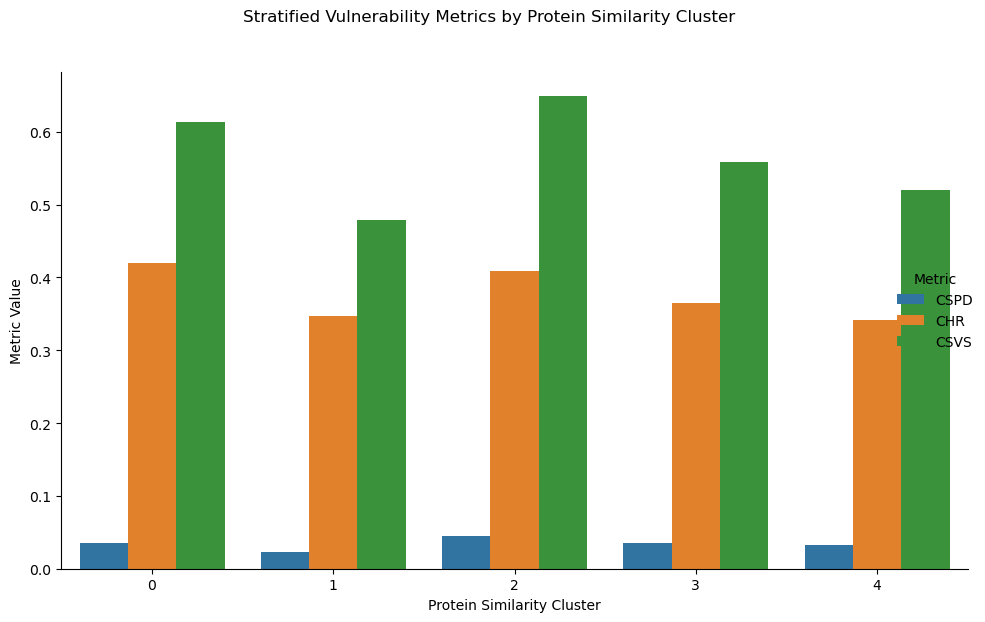

In [12]:
# Compute CSPD and CHR using your existing functions
CSPD_per_protein = compute_CSPD_per_protein(merged_df)
CSPD_abs = CSPD_per_protein.abs()
CHR_per_protein = compute_CHR_per_protein(merged_df)

# Normalize weights and compute CSVS
alpha = 1 / CSPD_abs.max()
beta = 1 / CHR_per_protein.max()
csvs = alpha * CSPD_abs + beta * CHR_per_protein
protein_csvs = pd.Series(csvs.values, index=csvs.index, name="CSVS")

# Combine into a metrics dataframe
metrics_df = pd.DataFrame({
    "Protein_ID": CSPD_abs.index,
    "CSPD": CSPD_abs,
    "CHR": CHR_per_protein,
    "CSVS": csvs
})

# Add metrics to a new copy of merged_df
merged_df_with_metrics = merged_df.merge(metrics_df, on="Protein_ID", how="left")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Get unique proteins with complete metric info and available embeddings
protein_ids = merged_df_with_metrics["Protein_ID"].dropna().unique()
valid_ids = [pid for pid in protein_ids if pid in protein_embeddings]
valid_embeddings = np.stack([protein_embeddings[pid] for pid in valid_ids])

# KMeans clustering on embeddings
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit_predict(valid_embeddings)
cluster_map = pd.Series(clusters, index=valid_ids, name="Protein_Cluster")

# Fix: convert cluster_map Series to DataFrame with a proper index name
cluster_df = cluster_map.rename_axis("Protein_ID").reset_index()

# Group metrics per protein and merge with cluster labels
summary_df = (
    merged_df_with_metrics
    .dropna(subset=["CSVS", "CSPD", "CHR"])
    .groupby("Protein_ID")[["CSPD", "CHR", "CSVS"]]
    .mean()
    .reset_index()  # Make Protein_ID a column
    .merge(cluster_df, on="Protein_ID", how="inner")  # Correct join
)


# Melt for plotting
summary_melted = summary_df.melt(
    id_vars=["Protein_ID", "Protein_Cluster"],
    value_vars=["CSPD", "CHR", "CSVS"],
    var_name="Metric", value_name="Value"
)


# Plot
g = sns.catplot(
    data=summary_melted,
    kind="bar",
    x="Protein_Cluster", y="Value", hue="Metric",
    height=6, aspect=1.5, ci=None
)
g.set_axis_labels("Protein Similarity Cluster", "Metric Value")
g._legend.set_title("Metric")
g.fig.suptitle("Stratified Vulnerability Metrics by Protein Similarity Cluster", y=1.03)
plt.tight_layout()


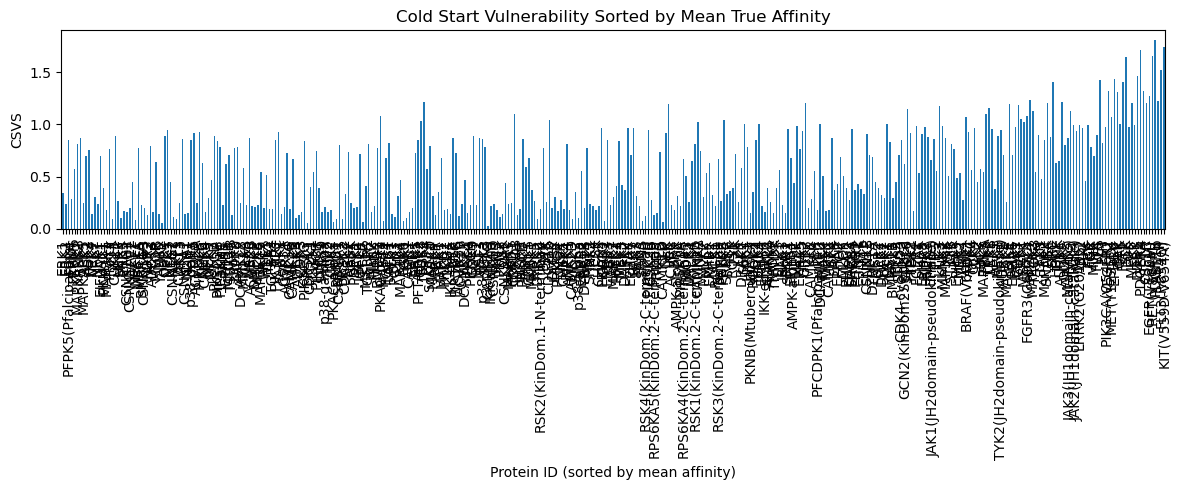

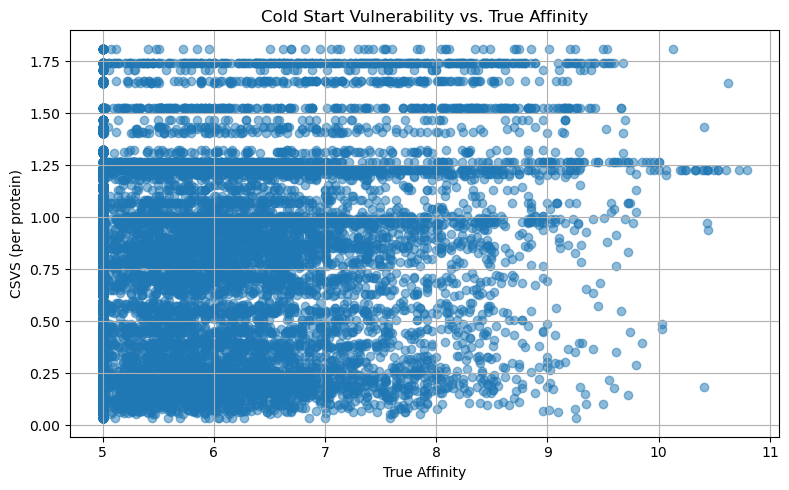

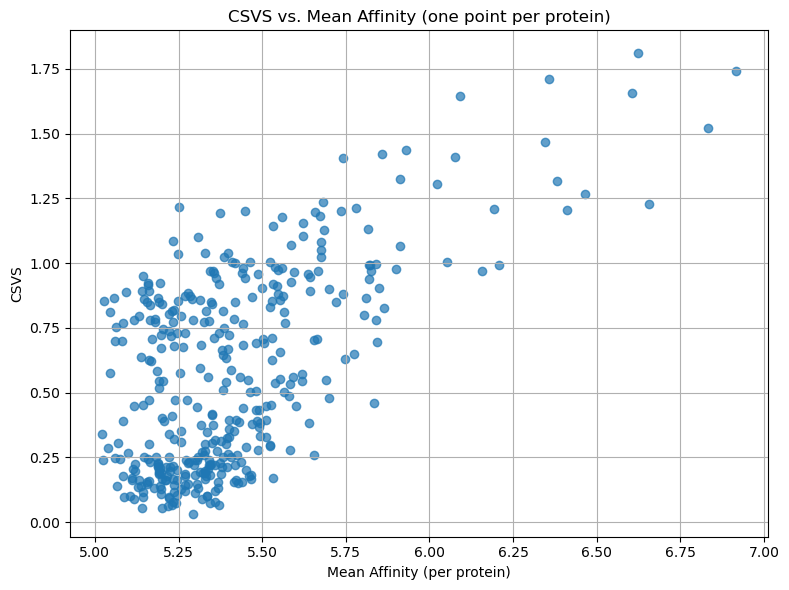

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Get the mean true affinity per protein from merged_df
mean_affinity_per_protein = merged_df.groupby("Protein_ID")["True_Label"].mean()

# Step 2: Ensure CSVS values are in a DataFrame for merging
csvs_df = pd.DataFrame({"Protein_ID": csvs.index, "CSVS": csvs.values})
csvs_df = csvs_df.set_index("Protein_ID")

# Step 3: Join with mean affinity
csvs_with_affinity = csvs_df.join(mean_affinity_per_protein)

# Step 4: Sort by True Affinity
csvs_sorted_by_affinity = csvs_with_affinity.sort_values("True_Label")

# Step 5: Plot
csvs_sorted_by_affinity["CSVS"].plot(kind='bar', figsize=(12, 5), title="Cold Start Vulnerability Sorted by Mean True Affinity")
plt.ylabel("CSVS")
plt.xlabel("Protein ID (sorted by mean affinity)")
plt.tight_layout()
plt.show()


# Step 1: Map per-protein CSVS to each row in merged_df
merged_df["CSVS"] = merged_df["Protein_ID"].map(csvs)

# Step 2: Plot CSVS vs. True Affinity
plt.figure(figsize=(8, 5))
plt.scatter(merged_df["True_Label"], merged_df["CSVS"], alpha=0.5)
plt.title("Cold Start Vulnerability vs. True Affinity")
plt.xlabel("True Affinity")
plt.ylabel("CSVS (per protein)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute mean affinity per protein
mean_affinity = merged_df.groupby("Protein_ID")["True_Label"].mean()
df_plot = pd.DataFrame({
    "CSVS": csvs_per_protein,
    "Mean_Affinity": mean_affinity
}).dropna()

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_plot["Mean_Affinity"], df_plot["CSVS"], alpha=0.7)
plt.xlabel("Mean Affinity (per protein)")
plt.ylabel("CSVS")
plt.title("CSVS vs. Mean Affinity (one point per protein)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Affinity Level

In [14]:
# File paths
unblinded_file = "new/crossval_predictions_GINConvNet_davis_b3.csv"
blinded_file = "new/concatenated_final_test_predictions.csv"

# Load both files
unblinded_df = pd.read_csv(unblinded_file)
blinded_df = pd.read_csv(blinded_file)

# Rename prediction columns to distinguish
unblinded_df = unblinded_df.rename(columns={"Predicted_Value": "Unblinded_Prediction"})
blinded_df = blinded_df.rename(columns={"Predicted_Value": "Blinded_Prediction"})

# Merge on Drug_ID and Protein_ID
merged_df = pd.merge(
    unblinded_df[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]],
    blinded_df[["Drug_ID", "Protein_ID", "True_Label", "Blinded_Prediction"]],
    on=["Drug_ID", "Protein_ID", "True_Label"]
)

In [15]:
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from scipy.spatial import ConvexHull

def compute_CHR_per_affinity_level(merged_df, min_affinity=5):
    """
    Computes CHR per floored integer affinity level ≥ min_affinity.
    """
    merged_df["Affinity_Level"] = merged_df["True_Label"].astype(int)
    CHR_dict = {}

    for level, group in merged_df.groupby("Affinity_Level"):
        if level < min_affinity:
            continue

        points_unblinded = group[["True_Label", "Unblinded_Prediction"]].values
        points_blinded = group[["True_Label", "Blinded_Prediction"]].values

        if len(points_unblinded) < 3:
            continue  # Convex hull requires ≥3 points

        try:
            hull = ConvexHull(points_unblinded)
            polygon = Polygon(points_unblinded[hull.vertices])

            inside_mask = np.array([polygon.covers(Point(p)) for p in points_blinded])
            CHR = (~inside_mask).sum() / len(points_blinded)
            CHR_dict[level] = CHR
        except:
            continue  # Skip degenerate or collinear cases

    return pd.Series(CHR_dict)


def compute_CSPD_per_affinity_level(merged_df, min_affinity=5):
    """
    Computes CSPD per floored integer affinity level ≥ min_affinity.
    """
    merged_df["NPD"] = (
        merged_df["Unblinded_Prediction"] - merged_df["Blinded_Prediction"]
    ) / merged_df["True_Label"]

    merged_df["Affinity_Level"] = merged_df["True_Label"].astype(int)
    #merged_df["Affinity_Level"] = merged_df["Blinded_Prediction"].astype(int)
    CSPD = merged_df.groupby("Affinity_Level")["NPD"].mean()
    return CSPD[CSPD.index >= min_affinity].abs().rename("CSPD")


def compute_CSVS_affinity_level(merged_df, min_affinity=5, alpha=None, beta=None):
    """
    Combines CSPD and CHR per integer affinity level ≥ min_affinity.
    Returns model-level CSVS and per-affinity-level scores.
    """
    CSPD = compute_CSPD_per_affinity_level(merged_df, min_affinity)
    CHR = compute_CHR_per_affinity_level(merged_df, min_affinity)

    # Align levels
    common_levels = CSPD.index.intersection(CHR.index)
    CSPD = CSPD.loc[common_levels]
    CHR = CHR.loc[common_levels]

    # Normalize weights
    if alpha is None:
        alpha = 1 / CSPD.max()
    if beta is None:
        beta = 1 / CHR.max()

    csvs_per_level = alpha * CSPD + beta * CHR
    csvs_model = csvs_per_level.mean()

    return csvs_model, csvs_per_level, alpha, beta


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_60175/1339141585.py:49: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


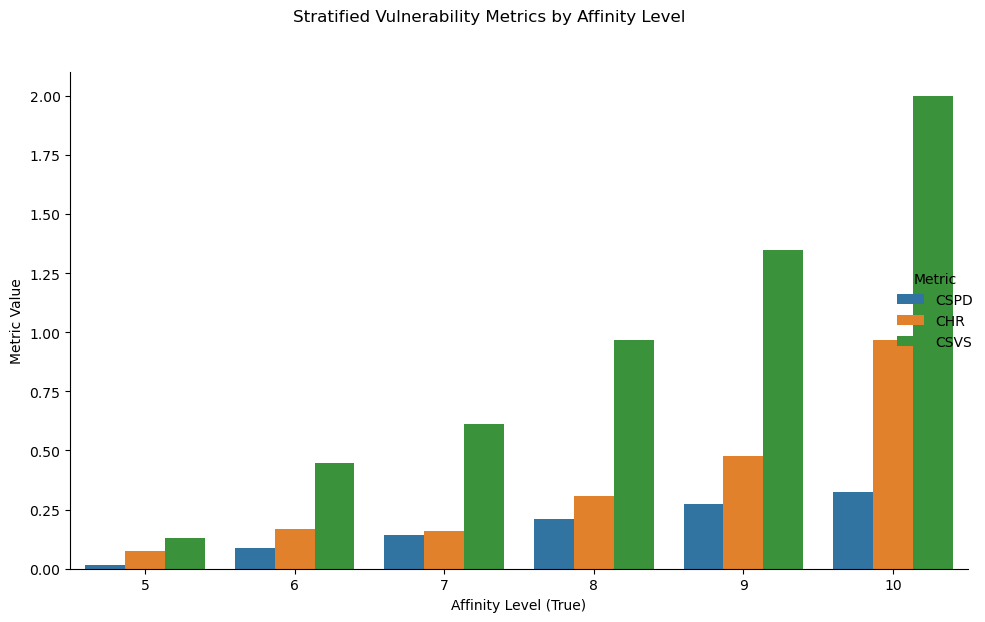

In [16]:
# Compute CSPD and CHR using affinity-level functions
CSPD_per_affinity = compute_CSPD_per_affinity_level(merged_df)
CHR_per_affinity = compute_CHR_per_affinity_level(merged_df)

# Align and normalize
common_levels = CSPD_per_affinity.index.intersection(CHR_per_affinity.index)
CSPD_abs = CSPD_per_affinity.loc[common_levels].abs()
CHR_aligned = CHR_per_affinity.loc[common_levels]

alpha = 1 / CSPD_abs.max()
beta = 1 / CHR_aligned.max()
csvs = alpha * CSPD_abs + beta * CHR_aligned
affinity_csvs = pd.Series(csvs.values, index=csvs.index, name="CSVS")


# Combine into metrics dataframe
metrics_df = pd.DataFrame({
    "Affinity_Level": CSPD_abs.index,
    "CSPD": CSPD_abs,
    "CHR": CHR_aligned,
    "CSVS": csvs
})

# Merge affinity levels into original data
#ON BLINDED PREDICTION!!!
merged_df["Affinity_Level"] = merged_df["True_Label"].astype(int)
merged_df_with_metrics = merged_df.merge(metrics_df, on="Affinity_Level", how="left")

# Group metrics per affinity level
summary_df = (
    merged_df_with_metrics
    .dropna(subset=["CSVS", "CSPD", "CHR"])
    .groupby("Affinity_Level")[["CSPD", "CHR", "CSVS"]]
    .mean()
    .reset_index()
)

# Melt for plotting
summary_melted = summary_df.melt(
    id_vars=["Affinity_Level"],
    value_vars=["CSPD", "CHR", "CSVS"],
    var_name="Metric", value_name="Value"
)

# Plot stratified by affinity
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.catplot(
    data=summary_melted,
    kind="bar",
    x="Affinity_Level", y="Value", hue="Metric",
    height=6, aspect=1.5, ci=None
)
g.set_axis_labels("Affinity Level (True)", "Metric Value")
g._legend.set_title("Metric")
g.fig.suptitle("Stratified Vulnerability Metrics by Affinity Level", y=1.03)
plt.tight_layout()


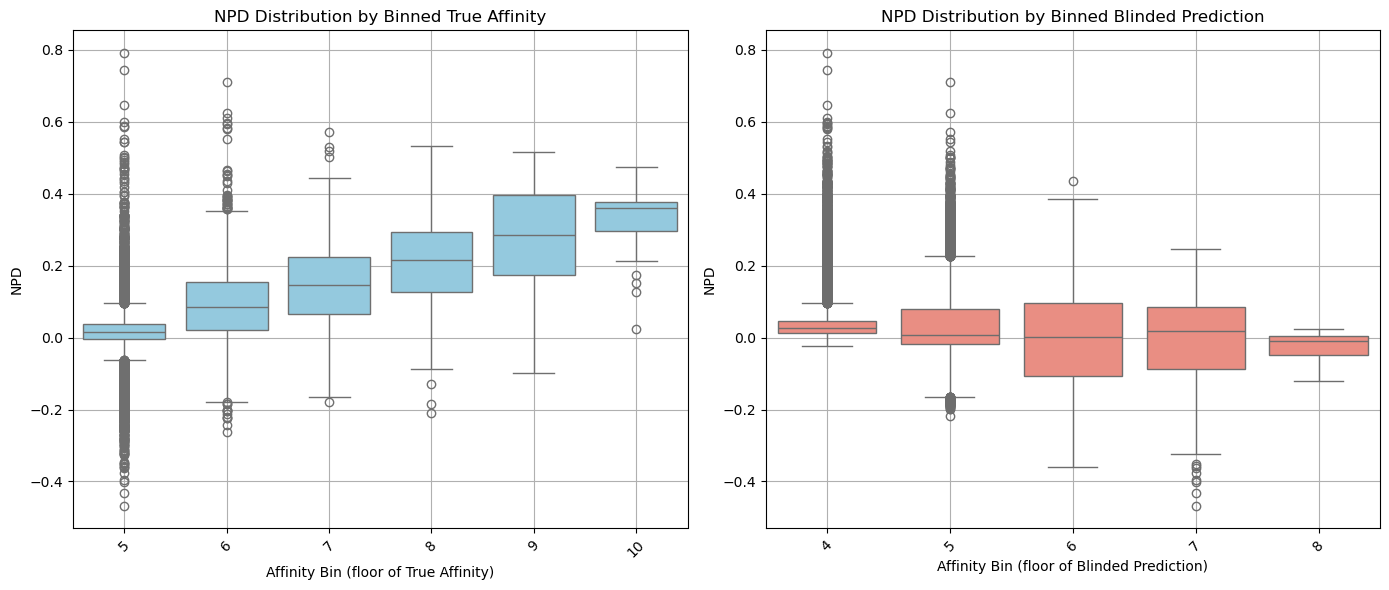

In [17]:
import numpy as np

# Create binned versions of True_Label and Blinded_Prediction
merged_df["Affinity_Bin_true"] = merged_df["True_Label"].astype(int)
merged_df["Affinity_Bin_blind"] = merged_df["Blinded_Prediction"].astype(int)

# Set up boxplots grouped by affinity bins (floored integers)
plt.figure(figsize=(14, 6))

# Boxplot grouped by binned true affinity
plt.subplot(1, 2, 1)
sns.boxplot(data=merged_df, x="Affinity_Bin_true", y="NPD", color="skyblue")
plt.title("NPD Distribution by Binned True Affinity")
plt.xlabel("Affinity Bin (floor of True Affinity)")
plt.ylabel("NPD")
plt.xticks(rotation=45)
plt.grid(True)

# Boxplot grouped by binned blinded prediction
plt.subplot(1, 2, 2)
sns.boxplot(data=merged_df, x="Affinity_Bin_blind", y="NPD", color="salmon")
plt.title("NPD Distribution by Binned Blinded Prediction")
plt.xlabel("Affinity Bin (floor of Blinded Prediction)")
plt.ylabel("NPD")
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()


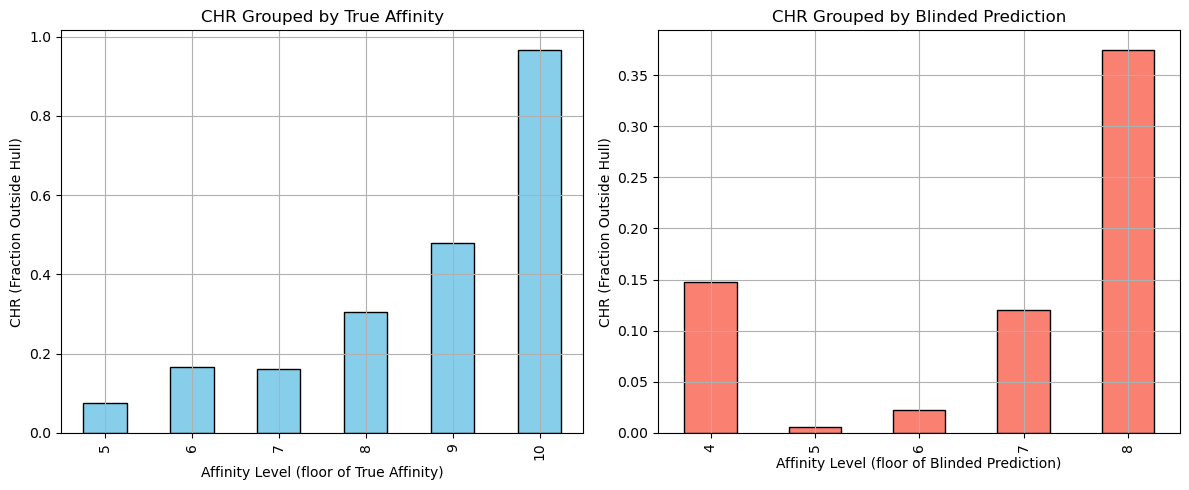

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon
from scipy.spatial import ConvexHull

# Assume merged_df is already in memory or was previously defined
# If not, this would raise an error — placeholder for now
try:
    merged_df
except NameError:
    raise ValueError("Please define or load merged_df before running this.")

def compute_CHR(merged_df, group_by_col, min_points=3):
    """
    Compute CHR stratified by either 'True_Label' or 'Blinded_Prediction' floor bins.
    """
    merged_df["Affinity_Level"] = merged_df[group_by_col].astype(int)
    CHR_dict = {}

    for level, group in merged_df.groupby("Affinity_Level"):
        if len(group) < min_points:
            continue

        points_unblinded = group[["True_Label", "Unblinded_Prediction"]].values
        points_blinded = group[["True_Label", "Blinded_Prediction"]].values

        if len(points_unblinded) < 3:
            continue  # Convex hull requires ≥3 points

        try:
            hull = ConvexHull(points_unblinded)
            polygon = Polygon(points_unblinded[hull.vertices])
            inside_mask = np.array([polygon.covers(Point(p)) for p in points_blinded])
            CHR = (~inside_mask).sum() / len(points_blinded)
            CHR_dict[level] = CHR
        except:
            continue  # Skip if hull construction fails

    return pd.Series(CHR_dict)

# Compute CHR grouped by true label and by blinded prediction
chr_true = compute_CHR(merged_df.copy(), "True_Label")
chr_blind = compute_CHR(merged_df.copy(), "Blinded_Prediction")

# Plotting comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
chr_true.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("CHR Grouped by True Affinity")
plt.xlabel("Affinity Level (floor of True Affinity)")
plt.ylabel("CHR (Fraction Outside Hull)")
plt.grid(True)

plt.subplot(1, 2, 2)
chr_blind.plot(kind="bar", color="salmon", edgecolor="black")
plt.title("CHR Grouped by Blinded Prediction")
plt.xlabel("Affinity Level (floor of Blinded Prediction)")
plt.ylabel("CHR (Fraction Outside Hull)")
plt.grid(True)

plt.tight_layout()
plt.show()


Model-level CSVS: 0.9166
5     0.128542
6     0.446913
7     0.611855
8     0.966986
9     1.345584
10    2.000000
dtype: float64


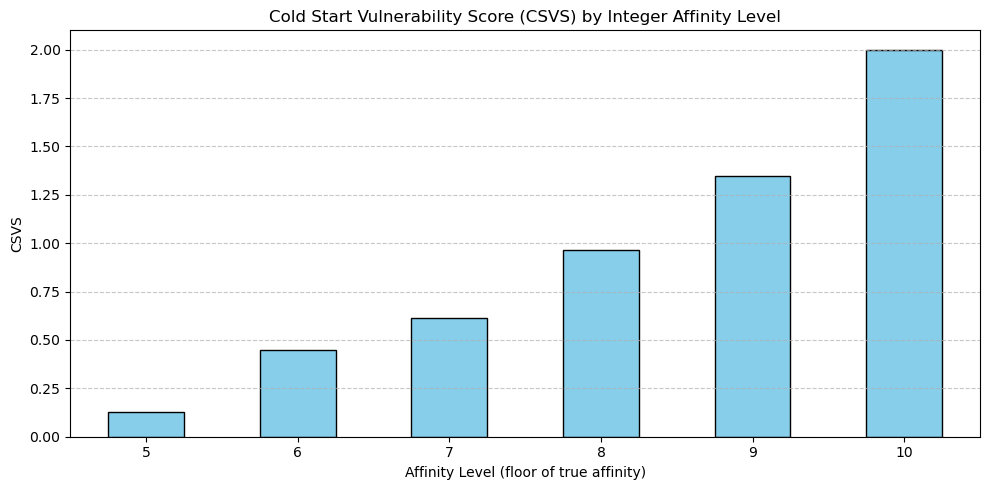

In [19]:
import matplotlib.pyplot as plt
csvs_model, csvs_per_level, alpha_used, beta_used = compute_CSVS_affinity_level(merged_df)


print(f"Model-level CSVS: {csvs_model:.4f}")
print(csvs_per_level)

# Plot CSVS per integer affinity level
csvs_per_level.sort_index().plot(
    kind='bar',
    figsize=(10, 5),
    title="Cold Start Vulnerability Score (CSVS) by Integer Affinity Level",
    color='skyblue',
    edgecolor='black'
)

plt.ylabel("CSVS")
plt.xlabel("Affinity Level (floor of true affinity)")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Drug?

In [20]:
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from scipy.spatial import ConvexHull

def compute_CHR_per_drug(merged_df):
    #based on convex hull:  how often the model predicts out-of-distribution values when faced with a cold-start protein.
    CHR_dict = {}

    for drug_id, group in merged_df.groupby("Drug_ID"):
        points_unblinded = group[["True_Label", "Unblinded_Prediction"]].values
        points_blinded = group[["True_Label", "Blinded_Prediction"]].values

        if len(points_unblinded) < 3:
            print("<3")
            continue  # Need at least 3 points for a convex hull

        try:
            hull = ConvexHull(points_unblinded)
            polygon = Polygon(points_unblinded[hull.vertices])

            inside_mask = np.array([polygon.covers(Point(p)) for p in points_blinded])
            outside_count = (~inside_mask).sum()
            CHR = outside_count / len(points_blinded)
            CHR_dict[drug_id] = CHR
        except Exception as e:
            print(f"[EXCEPTION] Protein: {protein_id} — {str(e)}")
            continue

    return pd.Series(CHR_dict)


def compute_CSPD_per_drug(merged_df):
    #how much a model’s prediction changes for the same input when the protein is blinded
    merged_df["NPD"] = (
        merged_df["Unblinded_Prediction"] - merged_df["Blinded_Prediction"]
    ) / merged_df["True_Label"]

    CSPD = merged_df.groupby("Drug_ID")["NPD"].mean()
    return CSPD.rename("CSPD")


def compute_CSVS_drug_level(merged_df, alpha=None, beta=None):
    # Step 1: Get per-protein CSPD and CHR
    CSPD_per_drug = compute_CSPD_per_drug(merged_df)
    CHR_per_drug = compute_CHR_per_drug(merged_df)

    # Align proteins
    common_drugs = CSPD_per_drug.index.intersection(CHR_per_drug.index)
    CSPD = CSPD_per_drug.loc[common_drugs].abs()
    CHR = CHR_per_drug.loc[common_drugs]

    # Normalize weights if not provided
    if alpha is None:
        alpha = 1 / CSPD.max()
    if beta is None:
        beta = 1 / CHR.max()

    # Compute CSVS for each protein
    csvs_per_drug = alpha * CSPD + beta * CHR
    print(csvs_per_drug)

    # Return the protein-level CSVS (mean across proteins)
    csvs_model = csvs_per_drug.mean()
    return csvs_model, csvs_per_drug, alpha, beta



In [21]:
import pandas as pd
import numpy as np
import os
import json,pickle
from collections import OrderedDict
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import networkx as nx

from tqdm import tqdm

def atom_features(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na','Ca', 'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb','Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H','Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr','Cr', 'Pt', 'Hg', 'Pb', 'Unknown']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    [atom.GetIsAromatic()])

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))
def smile_to_graph(smile):
    mol = Chem.MolFromSmiles(smile)
    
    c_size = mol.GetNumAtoms()
    
    features = []
    for atom in mol.GetAtoms():
        feature = atom_features(atom)
        features.append( feature / sum(feature) )

    edges = []
    for bond in mol.GetBonds():
        edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
    g = nx.Graph(edges).to_directed()
    edge_index = []
    for e1, e2 in g.edges:
        edge_index.append([e1, e2])
        
    return c_size, features, edge_index

# import pandas as pd

# Load DAVIS drug and protein sequences
davis_drugs = pd.read_csv("davis_b3_drugs.csv")

# Load PHAROS sequences (already matched)
pharos_df = pd.read_csv("pharos_with_ids.csv")
davis_df = pd.concat([
    pd.read_csv("../data/davis_b3_test.csv"),
    pd.read_csv("../data/davis_b3_train.csv")
], ignore_index=True)
davis_df["drug_id"] = davis_df["drug_id"].astype(str).str.strip()
davis_drugs["drug_id"] = davis_drugs["drug_id"].astype(str).str.strip()

davis_drug_ids = set(davis_df["drug_id"])
pharos_drug_ids = set(pharos_df["drug_id"])

# Filter DAVIS drugs to only those used in davis_df
filtered_davis_drugs = davis_drugs[davis_drugs["drug_id"].isin(davis_drug_ids)].rename(
    columns={"drug_id": "drug", "drug_seq": "smiles"}
)[["drug", "smiles"]]
print(len(filtered_davis_drugs))

# Get PHAROS drugs
pharos_drugs = pharos_df.rename(
    columns={"drug_id": "drug", "drug_smile": "smiles"}
)[["drug", "smiles"]]
print(len(pharos_drugs))

# Combine and deduplicate
drug_smiles_dict = pd.concat([filtered_davis_drugs, pharos_drugs]) \
    .drop_duplicates("drug") \
    .set_index("drug")["smiles"] \
    .to_dict()

smile_graph = {}
for drug_id, smile in tqdm(drug_smiles_dict.items()):
    try:
        graph_data = smile_to_graph(smile)
        smile_graph[drug_id] = graph_data
    except Exception as e:
        print(f"[{drug_id}] Error: {e}")



68
495


100%|██████████| 277/277 [00:00<00:00, 790.88it/s]


In [22]:
import sys
import os

# Add parent directory to Python path
sys.path.append(os.path.abspath(".."))


In [23]:
from models.ginconv import GINConvNet
import torch

# Instantiate model with default args (match training!)
model = GINConvNet()

# Load saved weights
model.load_state_dict(torch.load("saved_models/final_model_GINConvNet_davis_b3_1.pt", map_location="cpu"))

# Set to eval mode
model.eval()


/opt/anaconda3/envs/geometric/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/opt/anaconda3/envs/geometric/lib/python3.11/site-packages/torch_scatter/_version_cpu.so, 0x0006): Symbol not found: __ZN5torch3jit17parseSchemaOrNameERKNSt3__112basic_stringIcNS1_11char_traitsIcEENS1_9allocatorIcEEEEb
  Referenced from: <2711955E-91F2-3C44-B702-16E8D8D60085> /opt/anaconda3/envs/geometric/lib/python3.11/site-packages/torch_scatter/_version_cpu.so
  Expected in:     <66FB8649-BB87-3CD6-A177-462038DCAE02> /opt/anaconda3/envs/geometric/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/opt/anaconda3/envs/geometric/lib/python3.11/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: dlopen(/opt/anaconda3/envs/geometric/l

GINConvNet(
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=78, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_feature

In [24]:
from torch_geometric.data import Data

drug_embeddings = {}

for drug_id, (num_atoms, features, edge_index) in smile_graph.items():
    x = torch.tensor(features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    batch = torch.zeros(x.shape[0], dtype=torch.long)

    data = Data(x=x, edge_index=edge_index, batch=batch)

    with torch.no_grad():
        emb = model.extract_drug_embedding(data)
        drug_embeddings[drug_id] = emb.squeeze().numpy()


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_60175/3626892228.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  x = torch.tensor(features, dtype=torch.float)


In [25]:
print(len(drug_embeddings))
# Keep only drug_ids that exist in the embeddings dict
davis_drug_embeddings = {
    did: drug_embeddings[did]
    for did in davis_drug_ids if did in drug_embeddings
}
print(len(davis_drug_embeddings))
pharos_drug_embeddings = {
    did: drug_embeddings[did]
    for did in pharos_drug_ids if did in drug_embeddings
}
print(len(pharos_drug_embeddings))

277
68
209


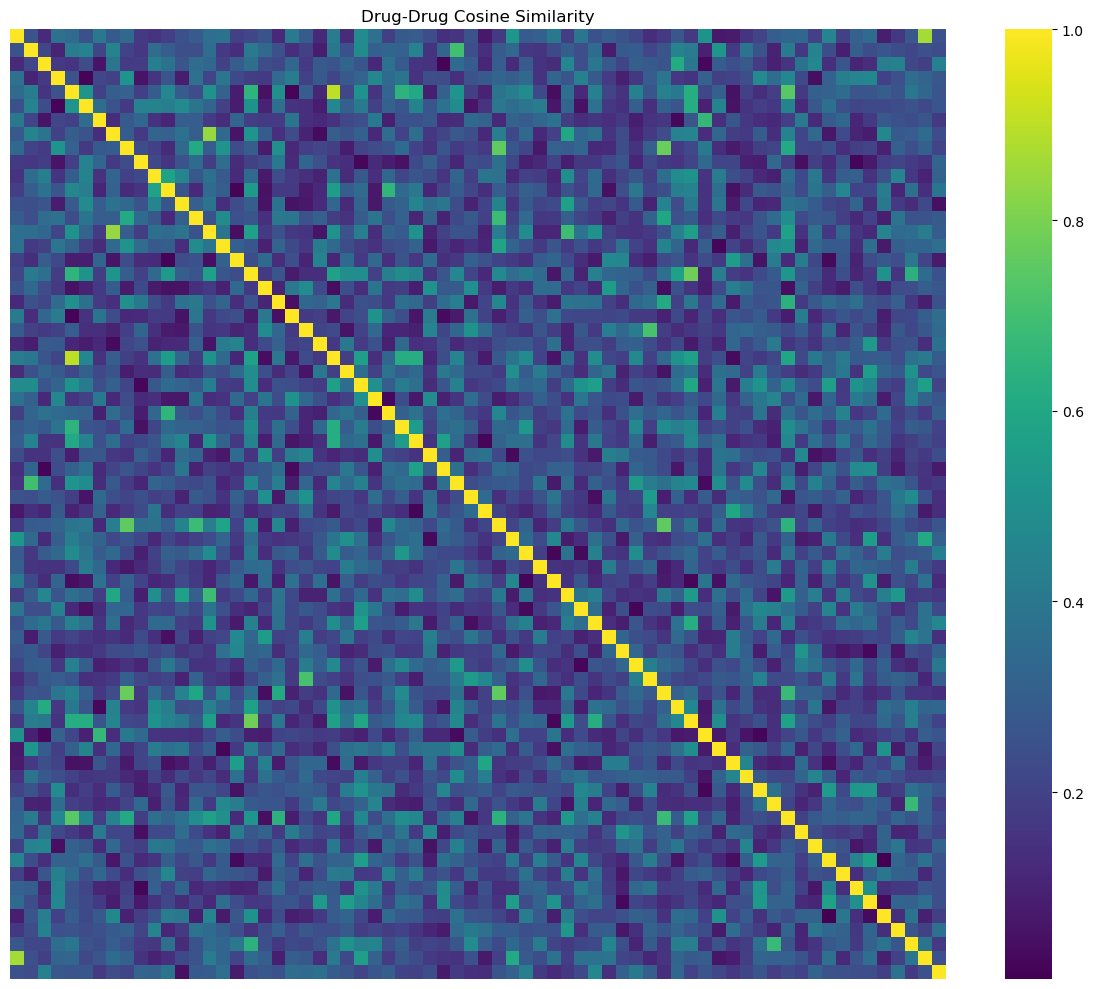

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

drug_ids = list(davis_drug_embeddings.keys())
X = np.stack([davis_drug_embeddings[did] for did in drug_ids])

similarity_matrix = cosine_similarity(X)

similarity_df = pd.DataFrame(similarity_matrix, index=drug_ids, columns=drug_ids)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(similarity_df, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title("Drug-Drug Cosine Similarity")
plt.tight_layout()
plt.show()


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_60175/2840138141.py:56: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


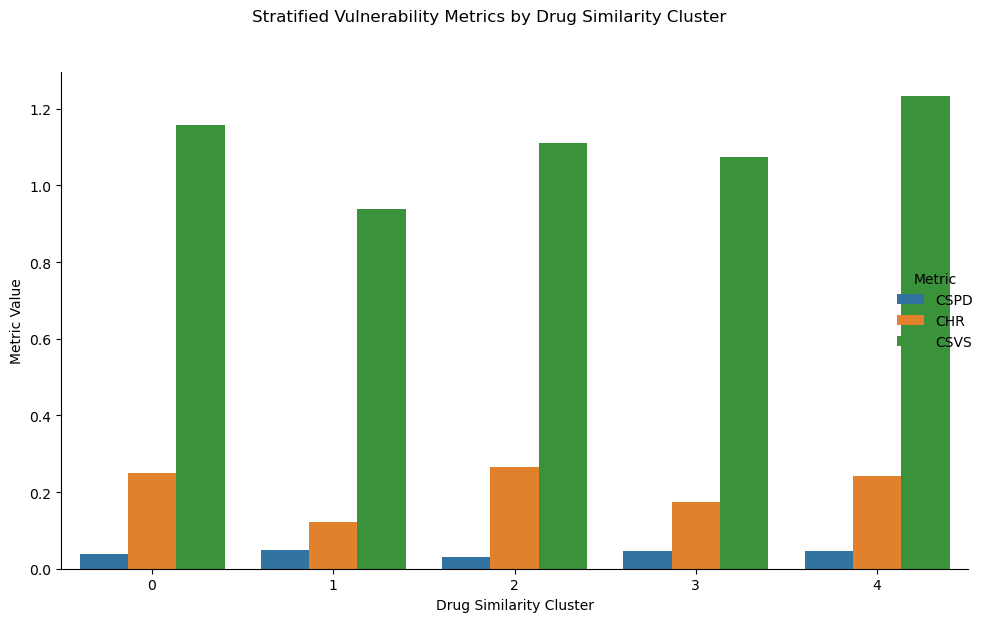

In [27]:
# Compute CSPD and CHR using your existing functions
CSPD_per_drug = compute_CSPD_per_drug(merged_df)
CSPD_abs = CSPD_per_drug.abs()
CHR_per_drug = compute_CHR_per_drug(merged_df)

# Normalize weights and compute CSVS
alpha = 1 / CSPD_abs.max()
beta = 1 / CHR_per_drug.max()
csvs = alpha * CSPD_abs + beta * CHR_per_drug
drug_csvs = pd.Series(csvs.values, index=csvs.index, name="CSVS")

# Ensure index types match for merging
CSPD_abs.index = CSPD_abs.index.astype(str)
CHR_per_drug.index = CHR_per_drug.index.astype(str)
csvs.index = csvs.index.astype(str)
merged_df["Drug_ID"] = merged_df["Drug_ID"].astype(str)

# Combine into a metrics dataframe
metrics_df = pd.DataFrame({
    "Drug_ID": CSPD_abs.index,
    "CSPD": CSPD_abs,
    "CHR": CHR_per_drug,
    "CSVS": csvs
})

# Add metrics to a new copy of merged_df
merged_df_with_metrics = merged_df.merge(metrics_df, on="Drug_ID", how="left")

# Clustering
drug_ids = merged_df_with_metrics["Drug_ID"].dropna().unique()
valid_ids = [did for did in drug_ids if did in drug_embeddings]
valid_embeddings = np.stack([drug_embeddings[did] for did in valid_ids])

kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit_predict(valid_embeddings)
cluster_map = pd.Series(clusters, index=valid_ids, name="Drug_Cluster")
cluster_df = cluster_map.rename_axis("Drug_ID").reset_index()

# Group and join with clusters
summary_df = (
    merged_df_with_metrics
    .dropna(subset=["CSVS", "CSPD", "CHR"])
    .groupby("Drug_ID")[["CSPD", "CHR", "CSVS"]]
    .mean()
    .reset_index()
    .merge(cluster_df, on="Drug_ID", how="inner")
)

# Melt and plot
summary_melted = summary_df.melt(
    id_vars=["Drug_ID", "Drug_Cluster"],
    value_vars=["CSPD", "CHR", "CSVS"],
    var_name="Metric", value_name="Value"
)

g = sns.catplot(
    data=summary_melted,
    kind="bar",
    x="Drug_Cluster", y="Value", hue="Metric",
    height=6, aspect=1.5, ci=None
)
g.set_axis_labels("Drug Similarity Cluster", "Metric Value")
g._legend.set_title("Metric")
g.fig.suptitle("Stratified Vulnerability Metrics by Drug Similarity Cluster", y=1.03)
plt.tight_layout()


# Model Level

how could i express model level ie overall cold start vulnerability. say for someone selecting between 2 models and they want to know which will be less vulnerable to cold start. 

define this only based ONLY off of davis and then show that see this model has a lower csv(as defined by my metric) and does better on pharos than this other model that i also do


just average protein, affinity, and drug level csvs
or do (triplet level) csvs
or use actual just model level...

In [45]:
# File paths
unblinded_file = "new/crossval_predictions_GINConvNet_davis_b3.csv"
blinded_file = "new/concatenated_final_test_predictions.csv"

# Load both files
unblinded_df = pd.read_csv(unblinded_file)
blinded_df = pd.read_csv(blinded_file)

# Rename prediction columns to distinguish
unblinded_df = unblinded_df.rename(columns={"Predicted_Value": "Unblinded_Prediction"})
blinded_df = blinded_df.rename(columns={"Predicted_Value": "Blinded_Prediction"})

# Merge on Drug_ID and Protein_ID
merged_df = pd.merge(
    unblinded_df[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]],
    blinded_df[["Drug_ID", "Protein_ID", "True_Label", "Blinded_Prediction"]],
    on=["Drug_ID", "Protein_ID", "True_Label"]
)

In [95]:
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from scipy.spatial import ConvexHull
from scipy.stats import wasserstein_distance

def compute_CHR_model_level_global(merged_df, min_points=3):
    """
    Computes model-level CHR as a single value:
    Fraction of all blinded points that fall outside
    the convex hull of all unblinded points.
    """
    points_unblinded = merged_df[["True_Label", "Unblinded_Prediction"]].values
    points_blinded = merged_df[["True_Label", "Blinded_Prediction"]].values

    if len(points_unblinded) < min_points:
        raise ValueError("Not enough unblinded points to construct convex hull.")

    try:
        hull = ConvexHull(points_unblinded)
        polygon = Polygon(points_unblinded[hull.vertices])

        inside_mask = np.array([polygon.covers(Point(p)) for p in points_blinded])
        chr_value = (~inside_mask).sum() / len(points_blinded)
        return chr_value

    except Exception as e:
        print(f"Convex hull computation failed: {e}")
        return np.nan



def compute_CSPD_model_level_global(merged_df, min_affinity=5):
    """
    Computes model-level CSPD as the mean absolute normalized prediction deviation (NPD)
    across all points with True_Label ≥ min_affinity.
    """
    df = merged_df.copy()
    df = df[df["True_Label"] >= min_affinity]

    # Avoid division by zero
    df = df[df["True_Label"] != 0]

    if df.empty:
        raise ValueError("No valid data points after applying min_affinity filter.")

    df["NPD"] = (df["Unblinded_Prediction"] - df["Blinded_Prediction"]) / df["True_Label"]
    cspd_value = df["NPD"].abs().mean()
    return cspd_value



from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points
from scipy.spatial import Delaunay, ConvexHull
from scipy.stats import wasserstein_distance
import numpy as np

def compute_signed_distance_to_hull(polygon, delaunay, point):
    """Compute signed distance to hull: negative if inside, positive if outside"""
    pt = Point(point)
    nearest = nearest_points(pt, polygon.boundary)[1]
    dist = pt.distance(nearest)
    is_inside = delaunay.find_simplex([point])[0] >= 0
    return -dist if is_inside else dist

def compute_vulnerability_fractions_from_arrays(unblinded, blinded):
    """
    Compute conformity-based vulnerability using signed distances to the convex hull.
    """
    # Build hull + triangulation
    hull = ConvexHull(unblinded)
    polygon = Polygon(unblinded[hull.vertices])
    delaunay = Delaunay(unblinded[hull.vertices])

    # Compute signed distances
    dists_unblinded = np.array([
        compute_signed_distance_to_hull(polygon, delaunay, p) for p in unblinded
    ])
    dists_blinded = np.array([
        compute_signed_distance_to_hull(polygon, delaunay, p) for p in blinded
    ])

    # Compute vulnerability fractions
    epsilon = 1e-8
    fractions_blinded = np.array([
        np.sum(dists_unblinded < db - epsilon) / len(dists_unblinded)
        for db in dists_blinded
    ])
    fractions_unblinded = np.array([
        np.sum(dists_unblinded < du - epsilon) / len(dists_unblinded)
        for du in dists_unblinded
    ])

    return fractions_unblinded, fractions_blinded, dists_blinded, dists_unblinded

def compute_CSVS_model_level_global(merged_df, min_affinity=5, alpha=1.0, beta=1.0):
    """
    Computes CSVS with CHR + rank-based hull distance shift.
    Returns:
        - scalar CSVS value
        - CSPD scalar
        - Rank shift vulnerability (DV)
        - CHR scalar
        - alpha, beta used
    """
    # Filter
    df = merged_df[merged_df["True_Label"] >= min_affinity].copy()
    if len(df) < 3:
        raise ValueError("Not enough points to compute convex hull vulnerability")

    # Extract point sets
    unblinded = df[["True_Label", "Unblinded_Prediction"]].values
    blinded = df[["True_Label", "Blinded_Prediction"]].values

    # Compute components
    CSPD = compute_CSPD_model_level_global(df, min_affinity)
    CHR = compute_CHR_model_level_global(df, min_affinity)

    # Compute signed distances and rank fractions
    _, blinded_fracs, dists_blinded, dists_unblinded = compute_vulnerability_fractions_from_arrays(unblinded, blinded)

    # Signed-rank-weighted DV
    DV_weights = np.where(dists_blinded > 0, 1.0, 0.2)  # full weight if outside, downweight if inside
    DV = np.nanmean(DV_weights * blinded_fracs)

    # Final CSVS
    csvs_model = alpha * CHR + beta * DV


    return csvs_model, CSPD, CHR, DV, alpha, beta




In [97]:
csvs_model, cspd, chr,DV, alpha_used, beta_used = compute_CSVS_model_level_global(merged_df, alpha=1, beta=1)
print(f"Model-level CSVS: {csvs_model:.4f}")
print(f"  CSPD: {cspd:.4f}, CHR: {chr:.4f}")
print(f" DV: {DV:.4f}")
print(f"  alpha: {alpha_used:.4f}, beta: {beta_used:.4f}")


Model-level CSVS: 0.1966
  CSPD: 0.0614, CHR: 0.0708
 DV: 0.1258
  alpha: 1.0000, beta: 1.0000


In [104]:
def compute_CSVS_on_pharos_against_unblinded(unblinded_df, pharos_df, alpha=1.0, beta=1.0):
    """
    Computes CSVS on Pharos using DAVIS unblinded as reference.
    """
    # Extract point arrays
    unblinded_points = unblinded_df[["True_Label", "Unblinded_Prediction"]].values
    blinded_points = pharos_df[["True_Label", "Predicted_Value"]].values

    # Rename for clarity
    pharos_df = pharos_df.rename(columns={"Predicted_Value": "Blinded_Prediction"})

    # Compute CHR and DV
    try:
        _, blinded_fracs, dists_blinded, dists_unblinded = compute_vulnerability_fractions_from_arrays(
            unblinded_points, blinded_points
        )
        CHR = np.mean([not Polygon(unblinded_points[ConvexHull(unblinded_points).vertices]).covers(Point(p))
                       for p in blinded_points])

        epsilon = 1e-8
        # Signed-rank-weighted DV
        DV_weights = np.where(dists_blinded > 0, 1.0, 0.2)  # full weight if outside, downweight if inside
        DV = np.nanmean(DV_weights * blinded_fracs)

    except Exception as e:
        print(f"Convex hull computation failed: {e}")
        CHR, DV = np.nan, np.nan

    # CSPD doesn't apply here (no unblinded prediction for Pharos)
    CSPD = np.nan

    # Compute CSVS
    csvs_model = alpha * CHR + beta * DV

    return csvs_model, CSPD, CHR, DV, alpha, beta


csvs_model, cspd, chr_val, dv_val, a_used, b_used = compute_CSVS_on_pharos_against_unblinded(
    unblinded_df=unblinded_df.rename(columns={"Predicted_Value": "Unblinded_Prediction"}),
    pharos_df=pd.read_csv("new/pharos_test_predictions_GINConvNet.csv"),
    alpha=1.0, beta=1.0
)

print(f"Pharos CSVS: {csvs_model:.4f}")
print(f"  CSPD: {cspd}, CHR: {chr_val:.4f}, DV: {dv_val:.4f}")


Pharos CSVS: 0.4678
  CSPD: nan, CHR: 0.2129, DV: 0.2549


Compare CSV<sub>model</sub> to True Generalization

Actual error on Pharos: RMSE, MAE, or NPD (normalized prediction deviation)

Directional stats: signed deviation from the DAVIS hull, etc.

Then correlate/contrast

support the claim: lower CSV<sub>model</sub> → better cold-start generalization.

# Random Preds

In [98]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(0)

# File paths
unblinded_file = "new/crossval_predictions_GINConvNet_davis_b3.csv"
blinded_file = "new/concatenated_final_test_predictions.csv"

# Load real DAVIS predictions
unblinded_df = pd.read_csv(unblinded_file)
blinded_df = pd.read_csv(blinded_file)

# Ensure you're merging only on (Drug_ID, Protein_ID), not predicted value
merge_cols = ["Drug_ID", "Protein_ID", "True_Label"]

# Merge the two datasets
merged = pd.merge(
    unblinded_df[merge_cols],
    blinded_df[merge_cols],
    on=["Drug_ID", "Protein_ID", "True_Label"],
    suffixes=("_unblinded", "_blinded")
)

# Number of valid matched points
num_points = len(merged)

# Generate random predictions for both sets
merged["Unblinded_Prediction"] = np.random.uniform(5, 10, size=num_points)
merged["Blinded_Prediction"] = np.random.uniform(5, 10, size=num_points)

# Drop any NaNs (just in case)
merged.dropna(subset=["True_Label", "Unblinded_Prediction", "Blinded_Prediction"], inplace=True)

# Compute CSVS
csvs_model, cspd, chr_val,DV, alpha_used, beta_used = compute_CSVS_model_level_global(merged, alpha=1, beta=1)

print(f"Random Model CSVS: {csvs_model:.4f}")
print(f"CSPD: {cspd:.4f}, CHR: {chr_val:.4f}")
print(f"DV: {DV:4f}")
print(f"Alpha: {alpha_used:.4f}, Beta: {beta_used:.4f}")


Random Model CSVS: 0.0549
CSPD: 0.3122, CHR: 0.0003
DV: 0.054688
Alpha: 1.0000, Beta: 1.0000


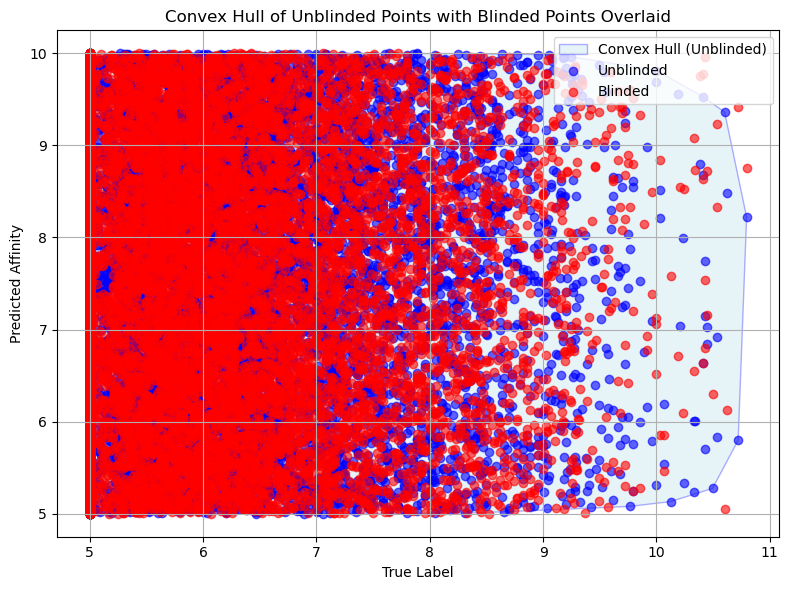

In [32]:
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
import numpy as np

# Prepare points for convex hull (True_Label vs Unblinded_Prediction)
points_unblinded = merged[["True_Label", "Unblinded_Prediction"]].values
points_blinded = merged[["True_Label", "Blinded_Prediction"]].values

# Compute convex hull
hull = ConvexHull(points_unblinded)
hull_vertices = points_unblinded[hull.vertices]

# Plot
plt.figure(figsize=(8, 6))

# Plot convex hull boundary
plt.fill(hull_vertices[:, 0], hull_vertices[:, 1], alpha=0.3, label="Convex Hull (Unblinded)", edgecolor="blue", facecolor="lightblue")

# Plot unblinded points
plt.scatter(points_unblinded[:, 0], points_unblinded[:, 1], label="Unblinded", color="blue", alpha=0.6)

# Plot blinded points
plt.scatter(points_blinded[:, 0], points_blinded[:, 1], label="Blinded", color="red", alpha=0.6)

# Labels and legend
plt.xlabel("True Label")
plt.ylabel("Predicted Affinity")
plt.title("Convex Hull of Unblinded Points with Blinded Points Overlaid")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [99]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(0)

# File paths
unblinded_file = "new/crossval_predictions_GINConvNet_davis_b3.csv"
blinded_file = "new/concatenated_final_test_predictions.csv"

# Load real DAVIS predictions
unblinded_df = pd.read_csv(unblinded_file)
blinded_df = pd.read_csv(blinded_file)

# Ensure you're merging only on (Drug_ID, Protein_ID), not predicted value
merge_cols = ["Drug_ID", "Protein_ID", "True_Label"]

# Merge the two datasets
merged = pd.merge(
    unblinded_df[merge_cols],
    blinded_df[merge_cols],
    on=["Drug_ID", "Protein_ID", "True_Label"],
    suffixes=("_unblinded", "_blinded")
)

# Number of valid matched points
num_points = len(merged)

mean_affinity = merged["True_Label"].mean()
epsilon = 1e-8
merged["Unblinded_Prediction"] = mean_affinity + np.random.uniform(-epsilon, epsilon, size=len(merged))
merged["Blinded_Prediction"] = mean_affinity

# Drop any NaNs (just in case)
merged.dropna(subset=["True_Label", "Unblinded_Prediction", "Blinded_Prediction"], inplace=True)

# Compute CSVS
csvs_model, cspd, chr_val,DV, alpha_used, beta_used = compute_CSVS_model_level_global(merged, alpha=1, beta=1)

print(f"Always pred Mean Aff Model CSVS: {csvs_model:.4f}")
print(f"CSPD: {cspd:.4f}, CHR: {chr_val:.4f}")
print(f"DV: {DV:4f}")
print(f"Alpha: {alpha_used:.4f}, Beta: {beta_used:.4f}")


Always pred Mean Aff Model CSVS: 0.0000
CSPD: 0.0000, CHR: 0.0000
DV: 0.000010
Alpha: 1.0000, Beta: 1.0000


In [100]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(0)

# File paths
unblinded_file = "new/crossval_predictions_GINConvNet_davis_b3.csv"
blinded_file = "new/concatenated_final_test_predictions.csv"

# Load real DAVIS predictions
unblinded_df = pd.read_csv(unblinded_file)
blinded_df = pd.read_csv(blinded_file)

# Ensure you're merging only on (Drug_ID, Protein_ID), not predicted value
merge_cols = ["Drug_ID", "Protein_ID", "True_Label"]

# Merge the two datasets
merged = pd.merge(
    unblinded_df[merge_cols],
    blinded_df[merge_cols],
    on=["Drug_ID", "Protein_ID", "True_Label"],
    suffixes=("_unblinded", "_blinded")
)

# Number of valid matched points
num_points = len(merged)

shuffled_unblinded = merged["True_Label"].sample(frac=1.0, random_state=42).reset_index(drop=True)
shuffled_blinded = merged["True_Label"].sample(frac=1.0, random_state=24).reset_index(drop=True)

merged["Unblinded_Prediction"] = shuffled_unblinded
merged["Blinded_Prediction"] = shuffled_blinded


# Drop any NaNs (just in case)
merged.dropna(subset=["True_Label", "Unblinded_Prediction", "Blinded_Prediction"], inplace=True)

# Compute CSVS
csvs_model, cspd, chr_val,DV, alpha_used, beta_used = compute_CSVS_model_level_global(merged, alpha=1, beta=1)

print(f"Shuffled Label Model Model CSVS: {csvs_model:.4f}")
print(f"CSPD: {cspd:.4f}, CHR: {chr_val:.4f}")
print(f"DV: {DV:4f}")
print(f"Alpha: {alpha_used:.4f}, Beta: {beta_used:.4f}")



Shuffled Label Model Model CSVS: 0.0207
CSPD: 0.1449, CHR: 0.0001
DV: 0.020591
Alpha: 1.0000, Beta: 1.0000


In [101]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(0)

# File paths
unblinded_file = "new/crossval_predictions_GINConvNet_davis_b3.csv"
blinded_file = "new/concatenated_final_test_predictions.csv"

# Load real DAVIS predictions
unblinded_df = pd.read_csv(unblinded_file)
blinded_df = pd.read_csv(blinded_file)

# Ensure you're merging only on (Drug_ID, Protein_ID), not predicted value
merge_cols = ["Drug_ID", "Protein_ID", "True_Label"]

# Merge the two datasets
merged = pd.merge(
    unblinded_df[merge_cols],
    blinded_df[merge_cols],
    on=["Drug_ID", "Protein_ID", "True_Label"],
    suffixes=("_unblinded", "_blinded")
)

# Number of valid matched points
num_points = len(merged)

epsilon = 1e-8
merged["Unblinded_Prediction"] = merged["True_Label"] + 1.0 + np.random.uniform(-epsilon, epsilon, size=len(merged))
merged["Blinded_Prediction"] = merged["True_Label"] + 2.0 + np.random.uniform(-epsilon, epsilon, size=len(merged))


# Drop any NaNs (just in case)
merged.dropna(subset=["True_Label", "Unblinded_Prediction", "Blinded_Prediction"], inplace=True)

# Compute CSVS
csvs_model, cspd, chr_val,DV, alpha_used, beta_used = compute_CSVS_model_level_global(merged, alpha=1, beta=1)

print(f"Biased Model CSVS: {csvs_model:.4f}")
print(f"CSPD: {cspd:.4f}, CHR: {chr_val:.4f}")
print(f"DV: {DV:4f}")
print(f"Alpha: {alpha_used:.4f}, Beta: {beta_used:.4f}")



Biased Model CSVS: 2.0000
CSPD: 0.1863, CHR: 1.0000
DV: 1.000000
Alpha: 1.0000, Beta: 1.0000


In [102]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(0)

# File paths
unblinded_file = "new/crossval_predictions_GINConvNet_davis_b3.csv"
blinded_file = "new/concatenated_final_test_predictions.csv"

# Load real DAVIS predictions
unblinded_df = pd.read_csv(unblinded_file)
blinded_df = pd.read_csv(blinded_file)

# Ensure you're merging only on (Drug_ID, Protein_ID), not predicted value
merge_cols = ["Drug_ID", "Protein_ID", "True_Label"]

# Merge the two datasets
merged = pd.merge(
    unblinded_df[merge_cols],
    blinded_df[merge_cols],
    on=["Drug_ID", "Protein_ID", "True_Label"],
    suffixes=("_unblinded", "_blinded")
)

# Number of valid matched points
num_points = len(merged)

merged["Unblinded_Prediction"] = merged["True_Label"] + np.random.normal(0, 0.5, size=len(merged))
merged["Blinded_Prediction"] = merged["True_Label"] + np.random.normal(0, 0.5, size=len(merged))


# Drop any NaNs (just in case)
merged.dropna(subset=["True_Label", "Unblinded_Prediction", "Blinded_Prediction"], inplace=True)

# Compute CSVS
csvs_model, cspd, chr_val,DV, alpha_used, beta_used = compute_CSVS_model_level_global(merged, alpha=1, beta=1)

print(f"Noise Inhjected Model CSVS: {csvs_model:.4f}")
print(f"CSPD: {cspd:.4f}, CHR: {chr_val:.4f}")
print(f"DV: {DV:4f}")
print(f"Alpha: {alpha_used:.4f}, Beta: {beta_used:.4f}")



Noise Inhjected Model CSVS: 0.0553
CSPD: 0.1045, CHR: 0.0003
DV: 0.054951
Alpha: 1.0000, Beta: 1.0000


In [103]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(0)

# File paths
unblinded_file = "new/crossval_predictions_GINConvNet_davis_b3.csv"
blinded_file = "new/concatenated_final_test_predictions.csv"

# Load real DAVIS predictions
unblinded_df = pd.read_csv(unblinded_file)
blinded_df = pd.read_csv(blinded_file)

# Ensure you're merging only on (Drug_ID, Protein_ID), not predicted value
merge_cols = ["Drug_ID", "Protein_ID", "True_Label"]

# Merge the two datasets
merged = pd.merge(
    unblinded_df[merge_cols],
    blinded_df[merge_cols],
    on=["Drug_ID", "Protein_ID", "True_Label"],
    suffixes=("_unblinded", "_blinded")
)

# Number of valid matched points
num_points = len(merged)

epsilon = 1e-8
merged["Unblinded_Prediction"] = merged["True_Label"] + np.random.uniform(-epsilon, epsilon, size=len(merged))

merged["Blinded_Prediction"] = 7.0  # Flat or biased guess


# Drop any NaNs (just in case)
merged.dropna(subset=["True_Label", "Unblinded_Prediction", "Blinded_Prediction"], inplace=True)

# Compute CSVS
csvs_model, cspd, chr_val,DV, alpha_used, beta_used = compute_CSVS_model_level_global(merged, alpha=1, beta=1)

print(f"Training-Memorizing Model CSVS: {csvs_model:.4f}")
print(f"CSPD: {cspd:.4f}, CHR: {chr_val:.4f}")
print(f"DV: {DV:4f}")
print(f"Alpha: {alpha_used:.4f}, Beta: {beta_used:.4f}")



Training-Memorizing Model CSVS: 1.9968
CSPD: 0.3227, CHR: 0.9984
DV: 0.998407
Alpha: 1.0000, Beta: 1.0000
